<a href="https://colab.research.google.com/github/Bhumii15/Face-emotion-detection/blob/main/Emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#setting up kaggle directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 61% 37.0M/60.3M [00:00<00:00, 161MB/s] 
100% 60.3M/60.3M [00:00<00:00, 178MB/s]


In [ ]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [ ]:
#Installing packages
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imghdr
import cv2
from PIL import Image
import tensorflow as tf


from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator,img_to_array

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras import layers,models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model

from keras.callbacks import CSVLogger


In [ ]:
from keras.layers import Flatten,Dense,Dropout
from keras.models import Model

In [ ]:
#setting up the directory to save the model

project_name = "Emotion_detection"

model_names = [
    'Custom_CNNFrom_Scratch',
    'Custom_CNN_With_Augementation',
    'VGG_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

#Base directoy which is google collab
base_dir = '/content/'

#create the project directory
project_dir = os.path.join(base_dir,project_name)
os.makedirs(project_dir,exist_ok=True)

#create subdirectory for each model
for each_model in model_names:
  model_dir = os.path.join(project_dir,each_model)
  os.makedirs(model_dir,exist_ok=True)

print(f"Project direcory structure created at: {project_dir}")

Project direcory structure created at: /content/Emotion_detection


In [ ]:
#Data cleaning

image_exts = ['jpeg','jpg','png']

data_dir = '/content/train'

for root,dirs,files in os.walk(data_dir):
  for file in files:
    file_path = os.path.join(root,file)

    try:

      #Check the type of current file
      file_type = imghdr.what(file_path)

      if file_type not in image_exts:
        print(f"Image not in extension list {file_path}")
        os.remove(file_path)

      else:
        #Process the image if needed
        img = cv2.imread(file_path)

    except Exception as e:
      print(f"Issue with file {file_path}. Error: {e}")
      os.remove(file_path)


In [ ]:
#Data analysis

def count_files_in_subdirectory(directory,set_name):

  counts = {}

  for item in os.listdir(directory):
    item_path = os.path.join(directory,item)

    #check if the item is present in the directory or not
    if os.path.isdir(item_path):
      counts[item] = len(os.listdir(item_path))

  #Convert the counts into pandas dataframe
  df = pd.DataFrame(counts,index=[set_name])
  return df

#Paths to train and test directory
train_dir = '/content/train'
test_dir = '/content/test'

#count the files
train_count = count_files_in_subdirectory(train_dir,'train')
test_count = count_files_in_subdirectory(test_dir,'test')

print(train_count)
print(test_count)

       disgust  neutral  angry   sad  fear  happy  surprise
train      436     4965   3995  4830  4097   7215      3171
      disgust  neutral  angry   sad  fear  happy  surprise
test      111     1233    958  1247  1024   1774       831


<Axes: >

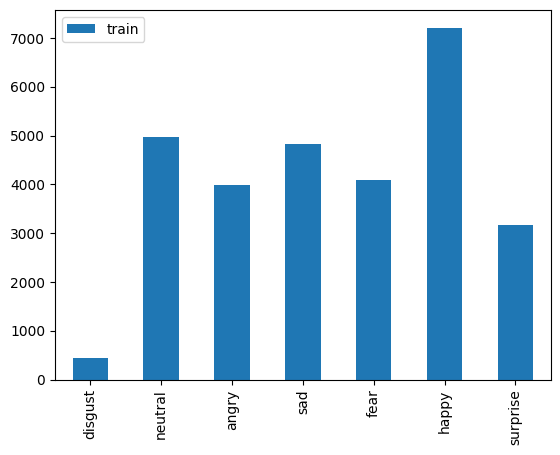

In [ ]:
train_count.transpose().plot(kind='bar')
#The graph shows about the class imbalance

<Axes: >

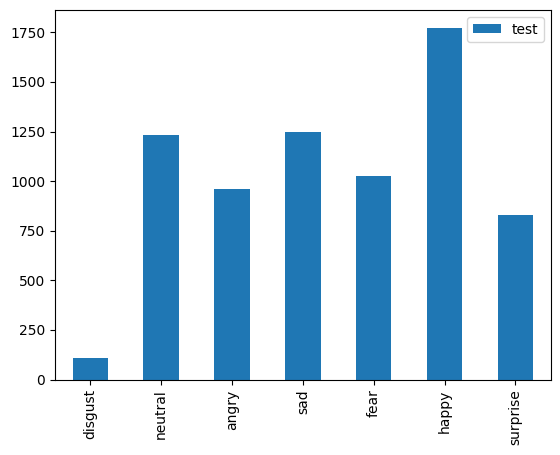

In [ ]:
test_count.transpose().plot(kind='bar')

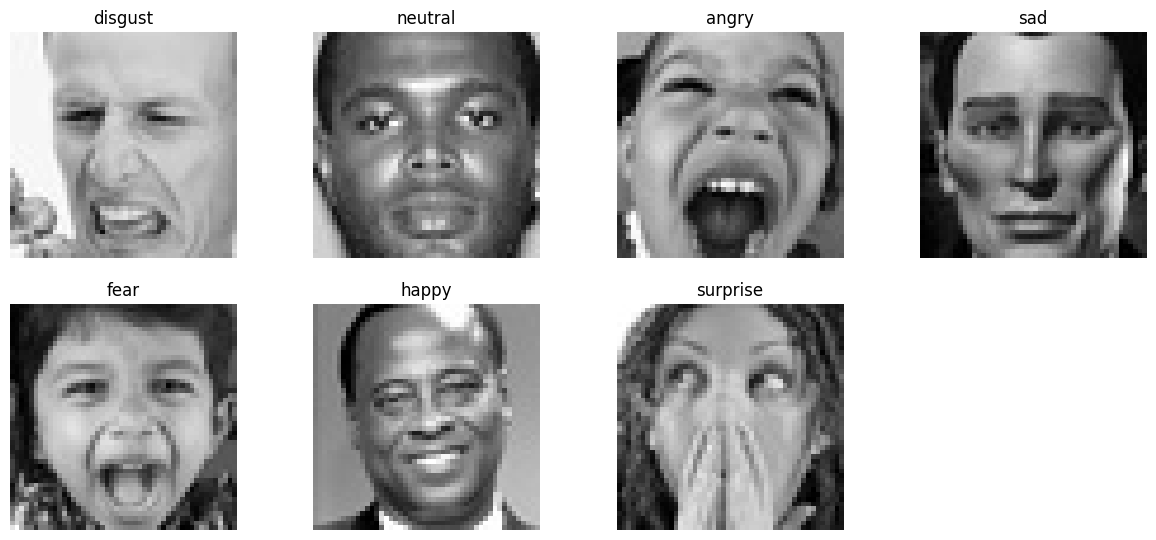

In [ ]:
#Plotting one image from each emotion

emotions = os.listdir(train_dir)
plt.figure(figsize = (15,10))

for i,emotion in enumerate(emotions,1):
  folder = os.path.join(train_dir,emotion)
  img_path = os.path.join(folder,os.listdir(folder)[42])
  img = plt.imread(img_path)
  plt.subplot(3,4,i)
  plt.imshow(img,cmap = 'gray')
  plt.title(emotion)
  plt.axis('off')


In [ ]:
#Plotting random images from the given dirctory

In [ ]:
def plot_images_from_directory(direcory_path,class_name,num_images=9):

  image_filenames = os.listdir(direcory_path)

  #if number of images are less than specified images then show all of them
  if len(image_filenames) < num_images:
      print(f"Only found {len(image_filenames)} images in {direcory_path}, displaying all of them")
      num_images = len(image_filenames)

  #Randomly select the specified number of images
  selected_images = random.sample(image_filenames,num_images)

  #Plotting random selected images
  fig,axes = plt.subplots(3,3,figsize = (5,5))
  axes = axes.ravel()

  for i,image_file in enumerate(selected_images):

    image_path = os.path.join(direcory_path,image_file)
    image = load_img(image_path)
    #image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Image: {class_name}")
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

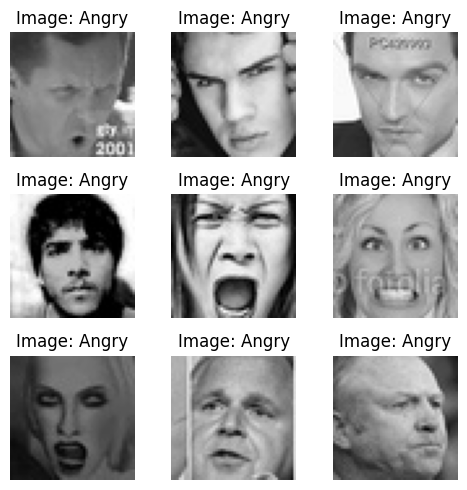

In [ ]:
#Placeholder for the directory path
angry_directory_path = '/content/train/angry'
plot_images_from_directory(angry_directory_path,class_name="Angry")

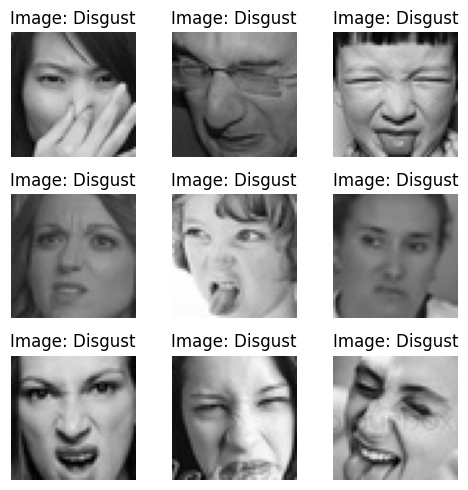

In [ ]:
disgust_directory_path = '/content/train/disgust'
plot_images_from_directory(disgust_directory_path,class_name="Disgust")

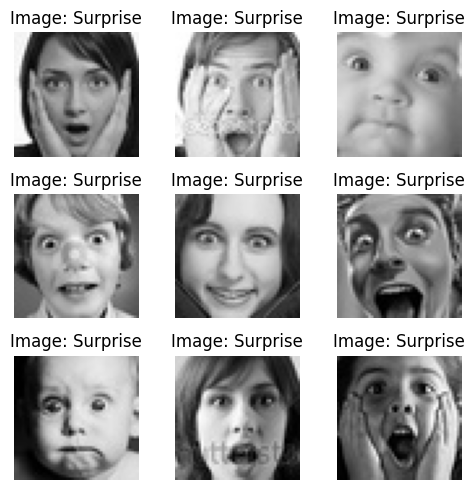

In [ ]:
surprise_directory_path = '/content/train/surprise'
plot_images_from_directory(surprise_directory_path,class_name='Surprise')

In [ ]:
#Checking Shapes and channels

image = '/content/train/angry/Training_10118481.jpg'

img = cv2.imread(image)

if img is not None:
  print("Shape",img.shape)

else:
  print("The image could not be loaded.Please check the path and file permissions.")

Shape (48, 48, 3)


In [ ]:
#Checking Shapes and channels

image_path = '/content/train/angry/Training_10118481.jpg'

img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)

if img is not None:
  print("Shape",img.shape)

else:
  print("The image could not be loaded.Please check the path and file permissions.")

Shape (48, 48)


In [ ]:
#Model 1 : Custom CNN from Scratch

In [ ]:
#Initializing the ImageGenerators

In [ ]:
#path to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [ ]:
#set some parameters
img_width,img_height = 48,48
batch_size = 64
epochs = 10
num_classes = 7

In [ ]:
#Rescale pixel values(0-255) to the [0,1] interval

data_generator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

#Automatically retrive images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width,img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset='training'
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width,img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset='validation'
)

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size = (img_width,img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale'
    #subset='training'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
#Accessing class labels for training data
train_class_labels = train_generator.class_indices
print("Training class labels:",train_class_labels)

validation_class_labels = validation_generator.class_indices
print("Validation class labels:",validation_class_labels)

test_class_labels = test_generator.class_indices
print("Test class labels:",test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
#Model building

In [ ]:
# Initialising the CNN
model = Sequential()

# Adding convolutional layers with activations on the same line for clarity
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

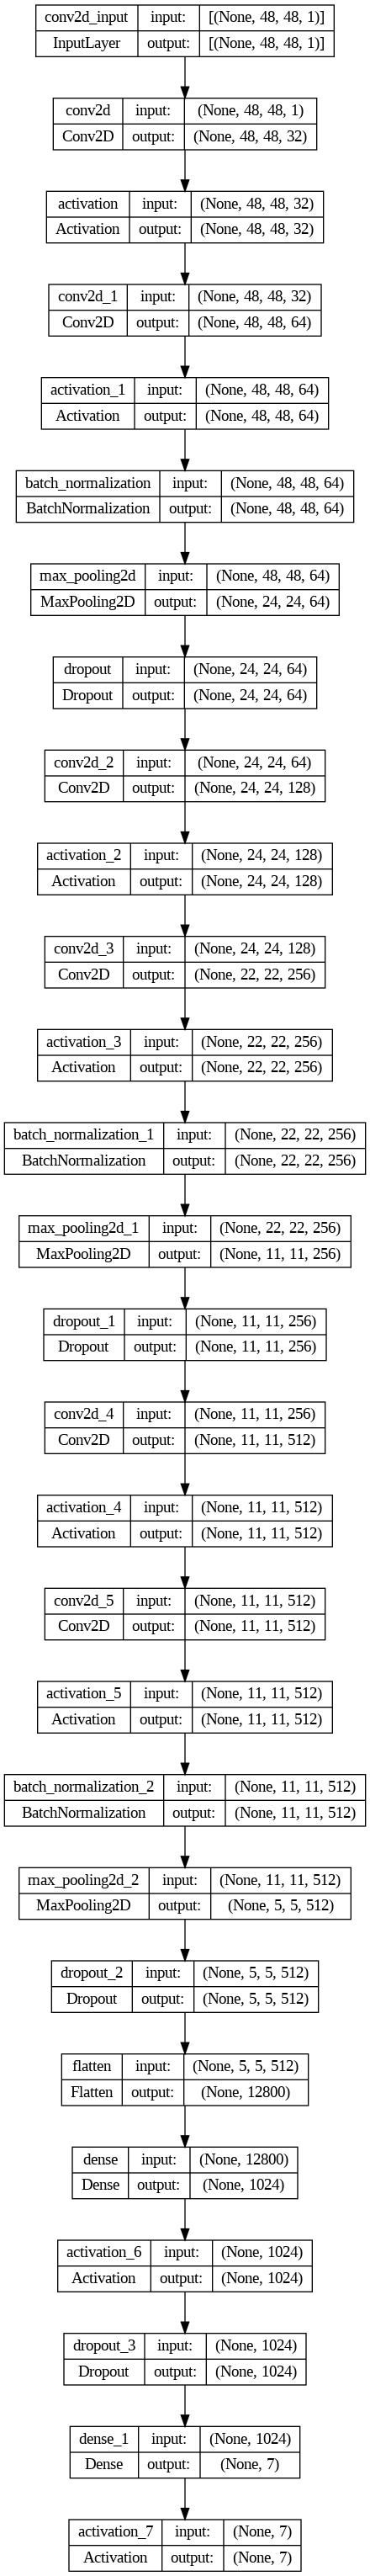

In [ ]:


plot_model(model,to_file='/content/Emotion_detection/Custom_CNNFrom_Scratch/Architecture.png',show_shapes=True,show_layer_names=True)

In [ ]:
#file path for the model checkpoint

cnn_path = '/content/Emotion_detection/Custom_CNNFrom_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path,name)
chk_path

'/content/Emotion_detection/Custom_CNNFrom_Scratch/Custom_CNN_model.keras'

In [ ]:
#callback to save the model checkpoint


checkpoint = ModelCheckpoint(filepath = chk_path,monitor='val_loss',verbose=1,save_best_only=True,mode='min')

In [ ]:
#callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',min_delta=0,patience=3,verbose=1,restore_best_weights=True)

In [ ]:
#callback to reduce learning rate

reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=6,verbose=1,min_delta=0.0001)

In [ ]:
#callback to log training data to a csv
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(cnn_path,'training.log'))

In [ ]:
#aggregating all callbacks into a list
callbacks = [checkpoint,earlystop,reduce_lr,csv_logger]

In [ ]:
#calculating steps fro eopch

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
#Model training

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = validation_steps_epoch,
    callbacks = callbacks
)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 12.4966 - accuracy: 0.2739
Epoch 1: val_loss improved from inf to 12.69185, saving model to /content/Emotion_detection/Custom_CNNFrom_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 40s 81ms/step - loss: 12.4966 - accuracy: 0.2739 - val_loss: 12.6919 - val_accuracy: 0.1754 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 10.3503 - accuracy: 0.3472
Epoch 2: val_loss improved from 12.69185 to 9.69874, saving model to /content/Emotion_detection/Custom_CNNFrom_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 26s 71ms/step - loss: 10.3503 - accuracy: 0.3472 - val_loss: 9.6987 - val_accuracy: 0.3851 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 8.3710 - accuracy: 0.3924
Epoch 3: val_loss improved from 9.69874 to 7.52846, saving model to /content/Emotion_detection/Custom_CNNFrom_Scratch/Custom_CN

In [ ]:
def plot_training_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

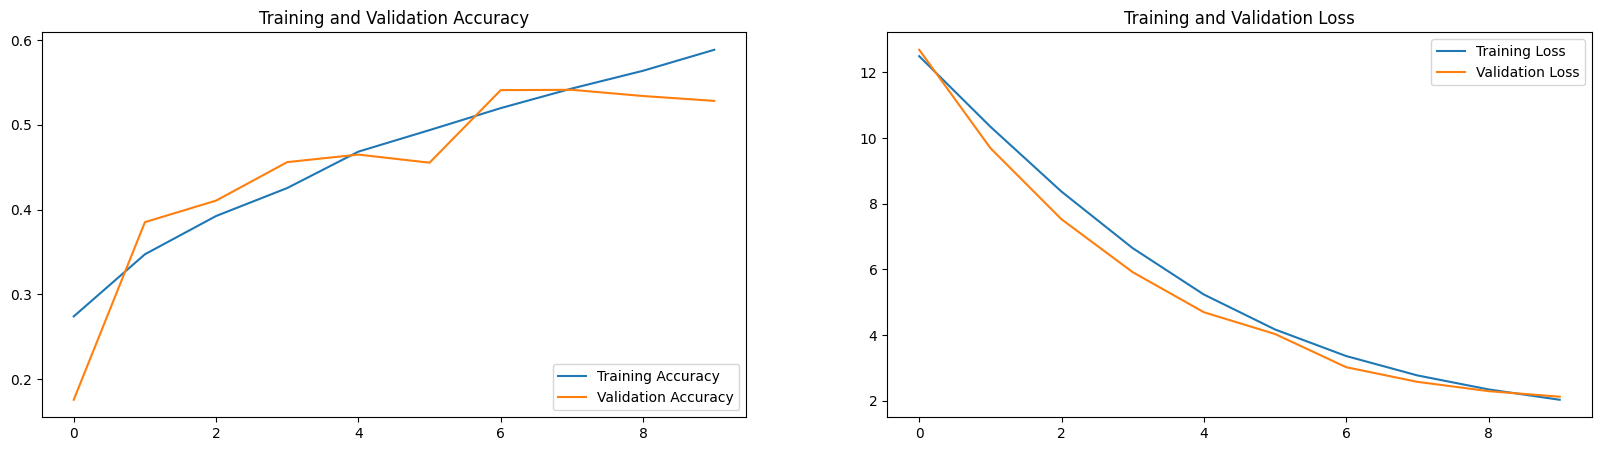

In [ ]:
plot_training_history(history)

In [ ]:
#Model evaluation

In [ ]:
train_loss,train_accu = model.evaluate(train_generator)
test_loss,test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f}, validation accuracy = {:.2f}".format(train_accu*100,test_accu*100))

113/113 [==============================] - 3s 26ms/step - loss: 2.1007 - accuracy: 0.5376
final train accuracy = 60.04, validation accuracy = 53.76


In [ ]:
#Plotting confusion matrix

113/113 [==============================] - 3s 21ms/step


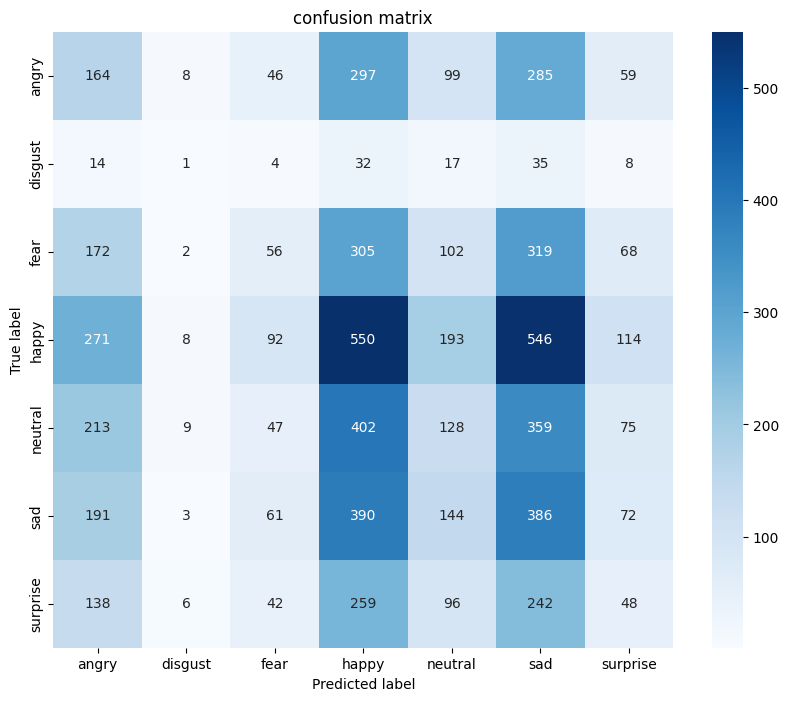

In [ ]:


true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator,steps = np.ceil(test_generator.samples/test_generator.batch_size)),axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes,predicted_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=class_labels,yticklabels=class_labels)
plt.title('confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
#printing the classification report

report = classification_report(true_classes,predicted_classes,target_names=class_labels)
print("classification report:\n",report)

classification report:
               precision    recall  f1-score   support

       angry       0.14      0.17      0.15       958
     disgust       0.03      0.01      0.01       111
        fear       0.16      0.05      0.08      1024
       happy       0.25      0.31      0.27      1774
     neutral       0.16      0.10      0.13      1233
         sad       0.18      0.31      0.23      1247
    surprise       0.11      0.06      0.08       831

    accuracy                           0.19      7178
   macro avg       0.15      0.15      0.14      7178
weighted avg       0.17      0.19      0.17      7178



In [ ]:
#Making predictions

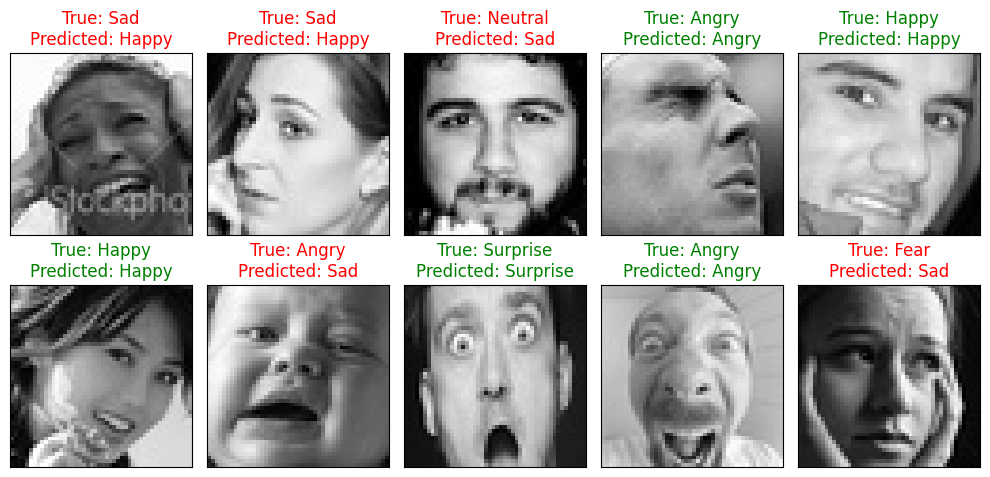

In [ ]:
#target class labels
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [ ]:
#Model 2: Image Augmentation

In [ ]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

#set some parameters
img_width,img_height = 48,48
batch_size = 64
epochs = 10
num_classes = 7

data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split=0.2

)

test_data_generator = ImageDataGenerator(rescale=1./255)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


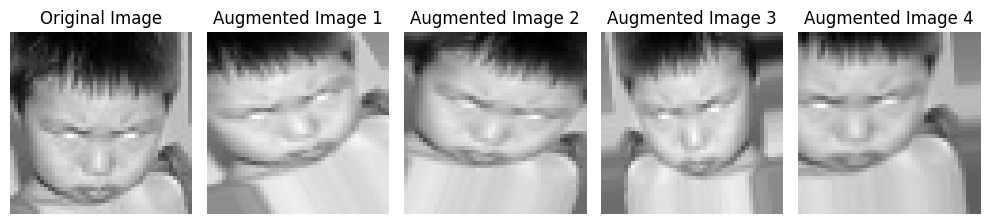

In [ ]:
image_path = '/content/train/angry/Training_10118481.jpg'

#Load and convert the image to an array
img = load_img(image_path,color_mode='grayscale',target_size=(img_width,img_height))
img_array = img_to_array(img)
img_array = img_array.reshape((1,)+img_array.shape)

#setting up the plot
fig,axes = plt.subplots(nrows=1,ncols=5,figsize=(10,4))
#plot the original image first

axes[0].imshow(img_array[0,:,:,0],cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

#plot the augmented image
for i,ax in enumerate(axes.flat[1:]):

  #generate a batch of augmented images
  aug_iter = data_generator.flow(img_array,batch_size=1)

  #get a random augmented image
  aug_img = next(aug_iter)[0]

  #plot the aigmented image
  ax.imshow(aug_img[:,:,0],cmap='gray')
  ax.set_title(f'Augmented Image {i+1}')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#Same cnn model as above

In [ ]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/Emotion_detection/Custom_CNN_With_Augementation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 12.4879 - accuracy: 0.2255
Epoch 1: val_loss improved from inf to 13.76240, saving model to /content/Emotion_detection/Custom_CNN_With_Augementation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 33s 85ms/step - loss: 12.4879 - accuracy: 0.2255 - val_loss: 13.7624 - val_accuracy: 0.1730 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 10.2558 - accuracy: 0.2387
Epoch 2: val_loss improved from 13.76240 to 9.93201, saving model to /content/Emotion_detection/Custom_CNN_With_Augementation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 31s 87ms/step - loss: 10.2558 - accuracy: 0.2387 - val_loss: 9.9320 - val_accuracy: 0.2252 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 8.1510 - accuracy: 0.2489
Epoch 3: val_loss improved from 9.93201 to 7.59247, saving model to /content/Emotion_detectio

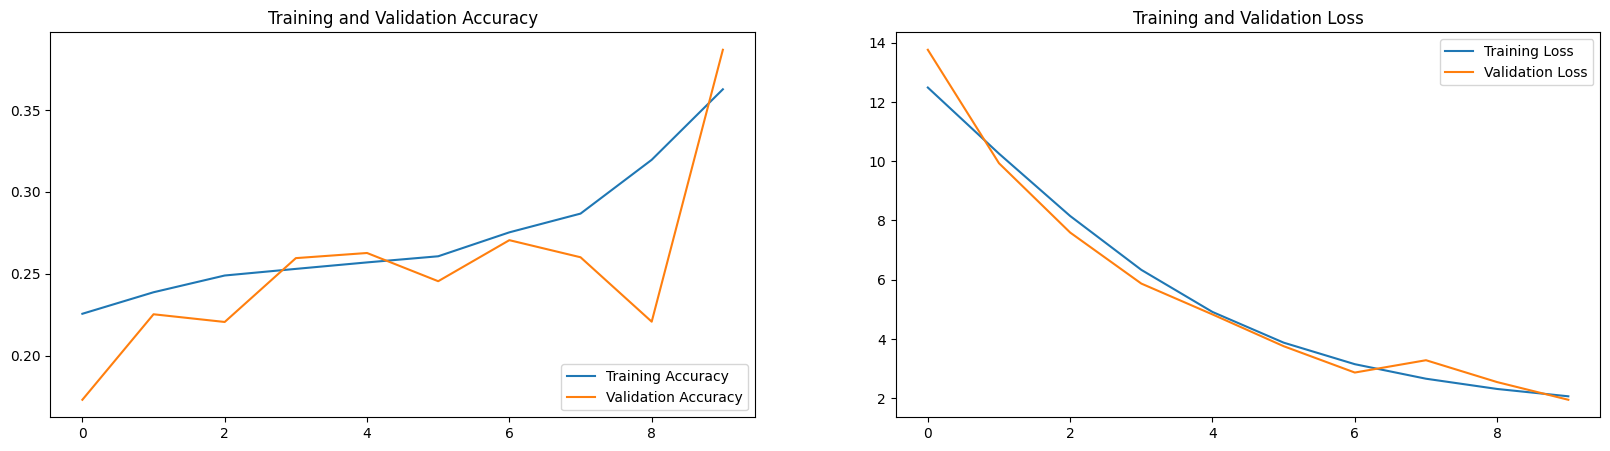

In [ ]:
plot_training_history(history)

In [ ]:
train_loss,train_accu = model.evaluate(train_generator)
test_loss,test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f}, validation accuracy ={:.2f}".format(train_accu*100,test_accu*100))

113/113 [==============================] - 3s 23ms/step - loss: 1.8714 - accuracy: 0.4345
final train accuracy = 39.68, validation accuracy =43.45


113/113 [==============================] - 3s 28ms/step


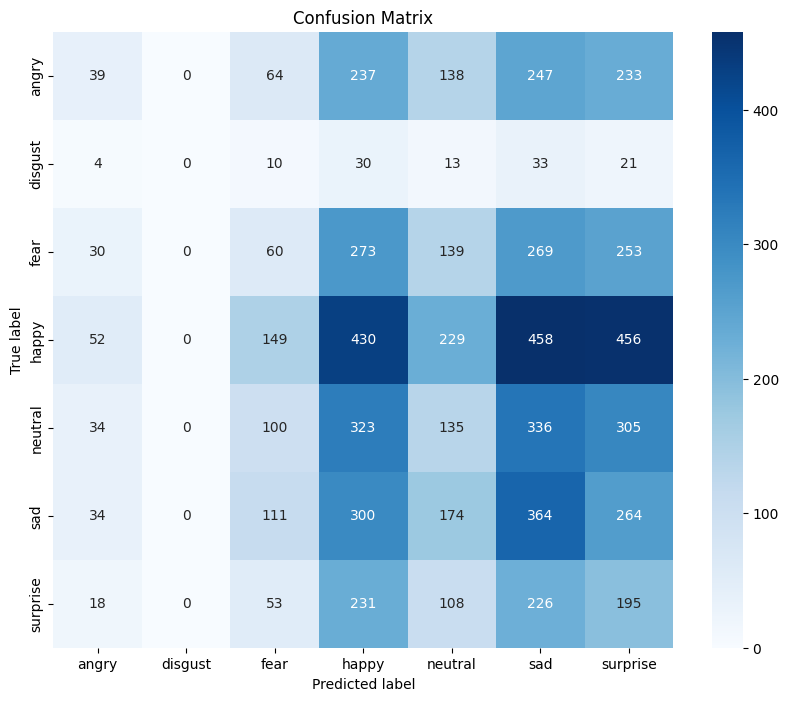

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.18      0.04      0.07       958
     disgust       0.00      0.00      0.00       111
        fear       0.11      0.06      0.08      1024
       happy       0.24      0.24      0.24      1774
     neutral       0.14      0.11      0.12      1233
         sad       0.19      0.29      0.23      1247
    surprise       0.11      0.23      0.15       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.17      0.16      7178



In [ ]:
#Model 3: Transfer Learning VGGNET

In [ ]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

#set some parameters
img_width,img_height = 224,224
batch_size = 64
epochs = 10
num_classes = 7

data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

test_preprocessor = ImageDataGenerator(
    rescale=1/255.
)

#retrive data automatically from the respective directory
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset = 'training',
    shuffle = True
)

test_generator = test_preprocessor.flow_from_directory(
    test_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
classes = 7

tf.keras.backend.clear_session()

#load the vgg16 base model excluding its top layers
vgg = VGG16(input_shape = (224,224,3),include_top = False,weights='imagenet')
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
#Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
  layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Flattening the layer and adding custom dense layers
x = Flatten()(vgg.output)

#Adding fully connected layer with relu activation and he normal initializer
x = Dense(1024,activation='relu',kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)

x = Dense(512,activation='relu',kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)

#adjusting the output layer
output = Dense(classes,activation='softmax',kernel_initializer='he_normal')(x)

#creating the model
model = Model(inputs = vgg.input,outputs = output)

#compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/Emotion_detection/VGG_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    epochs=10,
                    callbacks = callbacks)

Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 0.9714 - accuracy: 0.6358
Epoch 1: val_loss improved from 1.05648 to 1.01541, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 [==============================] - 490s 1s/step - loss: 0.9714 - accuracy: 0.6358 - val_loss: 1.0154 - val_accuracy: 0.6205
Epoch 2/10
396/449 [=========================>....] - ETA: 54s - loss: 0.9172 - accuracy: 0.6560

In [ ]:
plot_training_history(history)

NameError: name 'history' is not defined

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
#printing classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

In [ ]:
#Transfer learning - ResNet50

In [ ]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

#set some parameters
img_width,img_height = 224,224
batch_size = 64
epochs = 10
num_classes = 7

data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

test_preprocessor = ImageDataGenerator(
    rescale=1/255.
)

#retrive data automatically from the respective directory
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset = 'training',
    shuffle = True
)

test_generator = test_preprocessor.flow_from_directory(
    test_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
#Introducing class weights for imbalanced data

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(class_weight='balanced',classes=np.unique(classes),y=classes)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import GlobalAveragePooling2D


In [ ]:
input_shape = (224,224,3)

base_model = ResNet50(weights='imagenet',include_top=False,input_shape=input_shape)

model = Sequential(
    [
        base_model,
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dense(512,activation='relu'),
        Dropout(0.1),
        Dense(256,activation='relu'),
        Dropout(0.1),
        Dense(128,activation='relu'),
        Dropout(0.1),
        Dense(7,activation='softmax')
    ]
)

optimizer = Adamax(learning_rate=0.0001)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                         

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=6,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=200,
                          epochs=10,
                          validation_data=test_generator,
                          validation_steps=100,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                        )

Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 1.8186 - accuracy: 0.2727
Epoch 1: val_loss improved from inf to 1.89081, saving model to /content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
200/200 [==============================] - 301s 1s/step - loss: 1.8186 - accuracy: 0.2727 - val_loss: 1.8908 - val_accuracy: 0.2381
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 1.5864 - accuracy: 0.3842
Epoch 2: val_loss did not improve from 1.89081
200/200 [==============================] - 234s 1s/step - loss: 1.5864 - accuracy: 0.3842 - val_loss: 1.9895 - val_accuracy: 0.1675
Epoch 3/10
200/200 [==============================] - ETA: 0s - loss: 1.4078 - accuracy: 0.4513
Epoch 3: val_loss did not improve from 1.89081
200/200 [==============================] - 225s 1s/step - loss: 1.4078 - accuracy: 0.4513 - val_loss: 1.9888 - val_accuracy: 0.1711
Epoch 4/10
200/200 [==============================] - ETA: 0s 

In [ ]:
plot_training_history(train_history)

NameError: name 'plot_training_history' is not defined

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

In [ ]:
#Auc roc plot for each class

In [ ]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

In [ ]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')